# SaturationDetector use example
  this algorithm outputs the staring/ending locations of the saturated regions
  in seconds. Saturated regions are found by means of a tripe criterion:
  
         1. samples in a saturated region should have more energy than a given threshold.
         2. the difference between the samples in a saturated region should be smaller than a given threshold.
         3. the duration of the saturated region should be longer than a given threshold.
  
      note: The algorithm was designed for a framewise use and the returned timestamps are related to the first frame processed. Use reset() or configure() to restart the count.

In [6]:
import essentia.standard as es
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio 
from essentia import array as esarr
plt.rcParams["figure.figsize"] =(12,9)

In [2]:
def compute(x, frame_size=1024, hop_size=512, **kwargs):
    saturationDetector = es.SaturationDetector(frameSize=frame_size,
                                     hopSize=hop_size, 
                                     **kwargs)
    ends = []
    starts = []
    for frame in es.FrameGenerator(x, frameSize=frame_size,
                                   hopSize=hop_size, startFromZero=True):
        frame_starts, frame_ends = saturationDetector(frame)

        for s in frame_starts:
            starts.append(s)
        for e in frame_ends:
            ends.append(e)

    return starts, ends

# A synthetic gap

Lets start by testing the algorithm in the easiest possible scenario

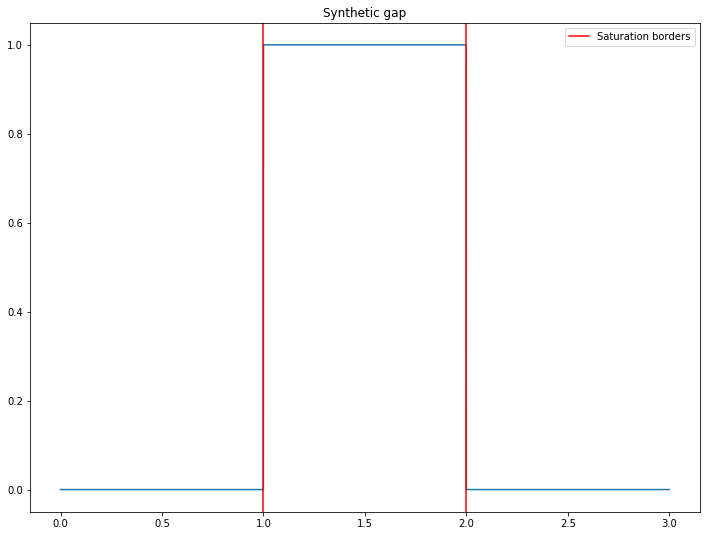

In [7]:
fs = 44100

signal = [0]*fs + [1]*fs + [0]*fs

starts, ends = compute(signal)


times = np.linspace(0, len(signal) / float(fs), len(signal))

plt.plot(times, signal)
plt.title('Synthetic gap')
for idx in range(len(starts)):
    l = plt.axvline(starts[idx], color='r')
    plt.axvline(ends[idx], color='r')
l.set_label('Saturation borders')
plt.legend()

# A real saturated signal
In this example, we feed a very noisy clip into the algorithm and show a couple of detected saturated regions.

In [21]:
fs = 44100.

audio_dir = '../../audio/'
audio = es.MonoLoader(filename='{}/{}'.format(audio_dir,
                      'recorded/distorted.wav'),
                      sampleRate=fs)()

In [22]:
Audio(audio, rate=fs)

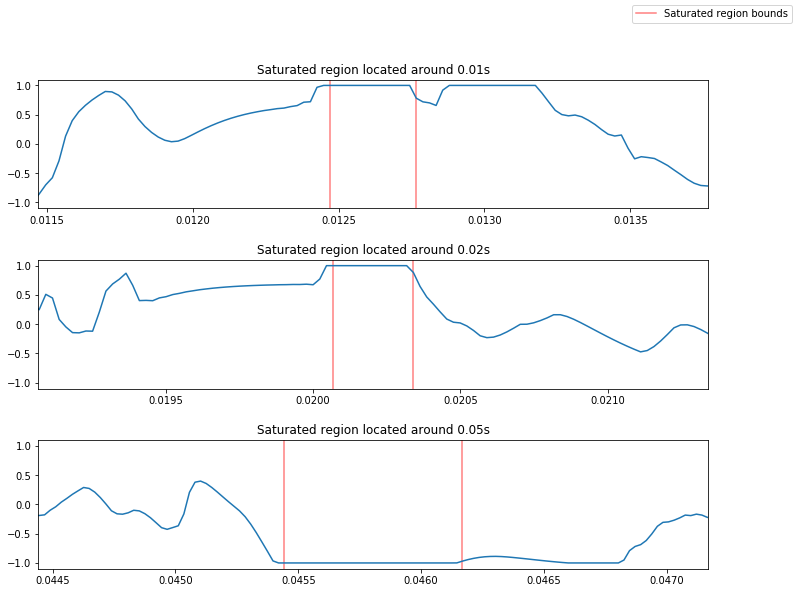

In [23]:
starts, ends = compute(audio)


times = np.linspace(0, len(audio) / float(fs), len(audio))

random_indexes = [3, 12, 31]

fig, ax = plt.subplots(len(random_indexes))
plt.subplots_adjust(hspace=.4)
for idx, ridx in enumerate(random_indexes):
    l1 = ax[idx].axvline(starts[ridx], color='r', alpha=.5)
    ax[idx].axvline(ends[ridx], color='r', alpha=.5)
    ax[idx].plot(times, audio)
    ax[idx].set_xlim([starts[ridx] - .001, ends[ridx] + .001])
    ax[idx].set_title('Saturated region located around {:.2f}s'.format(np.mean([ends[ridx], starts[ridx]])))
    
l1.set_label('Saturated region bounds')
fig.legend()

# Parameters
this is an explanation of the most relevant parameters of the algorithm

- **differentialThreshold.** This algorithm works on top of the derivative of the signal. This parameter control how small the first derivative of a single sample has to be in order to be considered a saturated sample.

- **energyThreshold.** This parameter filters out saturated regions with smaller energy. The main idea is to discard everything that is not loud.

- **minimumDuration.** This parameter filters out the shortest segments. The main motivation is that if the saturated region is too short it will not be perceived.